## Notebook for deploying Cognite Function

### Authentication

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import os
import sys
import ast

from cognite.client.data_classes import functions

from initialize import initialize_client

func_suffix = "Development"

In [2]:
ts_input_name = "VAL_11-LT-95034A:X.Value"
ts_output_name = "VAL_11-LT-95034A:X.CDF.D.AVG.LeakValue"#f"VAL_11-LT-95034A:X.D.LeakValue"
tank_volume = 1400
derivative_value_excl = 0.002
# start_date = datetime(2023, 3, 21, 1, 0, 0)
function_name = "avg-drainage-rate"
schedule_name = "avg-drainage-rate-schedule"

data_dict = {'tot_days':0, 'tot_minutes':15, # convert date to str to make it JSON serializable
            'ts_input_name':ts_input_name, 'ts_output_name':ts_output_name,
            'derivative_value_excl':derivative_value_excl, 'tank_volume':tank_volume,
            'cdf_env':"dev", 'dataset_id': 1832663593546318,
            'backfill': False, 'backfill_period': 14,
            'function_name': function_name, 'schedule_name': schedule_name,
            'lowess_frac': 0.001, 'lowess_delta': 0.01} # NB: change dataset id when going to dev/test/prod!

cron_interval = "15" # 15

In [3]:
# Set limit on function runtime (initial write takes long time)
func_limits = functions.FunctionsLimits(timeout_minutes=60, cpu_cores=0.25, memory_gb=1, runtimes=["py39"], response_size_mb=2.5)
# console.log() to find out where error occurs in code

In [4]:
client = initialize_client(data_dict["cdf_env"], cache_token=False)

### Upload file to be associated with your dataset

In [5]:
folder = os.getcwd().replace("\\", "/")
# function_path = "handler.py"
function_path = "zippy_new.zip"

uploaded = client.files.upload(path=f"{folder}/{function_path}", name=function_path, data_set_id=data_dict["dataset_id"])

### Deploy Cognite function

In [6]:
# Create function for initial writing (only called once, not on schedule)
func_drainage = client.functions.create(
    name=f"avg-drainage-rate-new",
    external_id=f"avg-drainage-rate-new",
    # folder=".",
    file_id=uploaded.id,
)

In [8]:
func_drainage = client.functions.retrieve(external_id=f"avg-drainage-rate-new")
func_drainage.status
# func_drainage.list_calls().to_pandas()

'Ready'

In [43]:
# Important! Do single call to function to transform entire time series
# If doing this initial call from schedule it will time out (after ca 15 min)!
call_func_drainage = func_drainage.call(data=data_dict)

### Schedule Cognite function

In [9]:
# AFTER initial call, schedule can be called
func_drainage_schedule = client.functions.schedules.create(
    name=f"avg-drainage-rate-schedule-new",
    cron_expression=f"*/{cron_interval} * * * *", # every 15 min
    function_id=func_drainage.id,
    #client_credentials=client,
    description="Calculation scheduled every hour",
    data=data_dict
)

In [23]:
sid = client.functions.schedules.list(function_id=func_drainage.id).to_pandas().id[0]
scid = func_drainage.list_calls(schedule_id=sid, limit=-1).to_pandas()
# resp = func_drainage.retrieve_call(id=scid).get_response()
scid["date"] = pd.to_datetime(scid["scheduled_time"], unit="ms").astype(str)
# backfill_id = scid[scid["date"].astype(str) == "2023-10-22 17:30:00"]["id"].iloc[0]
# backfill_id
pd.Timestamp.now()

t1 = pd.DataFrame([1,5,3,4,3,6], index=pd.date_range(start=datetime(2023,10,1), end=datetime(2023,10,6)), columns=["Test"])
t2 = pd.DataFrame([1,5,1,7,3,5], index=pd.date_range(start=datetime(2023,10,1), end=datetime(2023,10,6)), columns=["Test"])

incr = t2[t2["Test"] > t1["Test"]].index
decr = t2[t2["Test"] < t1["Test"]].index
incr.union(decr, sort=True)

DatetimeIndex(['2023-10-04', '2023-10-03', '2023-10-06'], dtype='datetime64[ns]', freq=None)

### NB: Delete function

In [19]:
client.functions.delete(id=func_drainage.id)

client.time_series.delete(external_id=f"VAL_11-LT-95034A:X.CDF.D.AVG.LeakValue{func_suffix}")

## Experimental

### Generalizing Cognite Functions - sketch

In [11]:
ts_all = {
        'ts_A': {'name':'A', 'granularity':15, 'var':'a'},
        'ts_B': {'name':'B', 'granularity':10, 'b_specific':[1,2,3]},
        'ts_X': {'name':'X', 'max_days':8, 'thermo_coeff': 0.05, 'filter':'lowess'},
        'ts_Y': {'name':'Y', 'tot_days': 40}
        }

In [ ]:
func_drainage = client.functions.retrieve(external_id="draiange")
func_thermo = client.functions.retrieve(external_id="thermo")

func_drainage_schedule = []
func_thermo_schedule = []

# Create individual schedules for three time series running drainage-Cognite-function
for ts in ['A', 'B', 'Y']:
    func_schedule = client.functions.schedules.create(
        name=f"avg-leak-{ts}",
        cron_expression=f"*/{cron_interval} * * * *",
        function_id=func_drainage.id, # SAME function id
        description=f"Leak rate calculation for time series {ts}",
        data=ts_all[f'ts_{ts}'] # DIFFERENT data dictionaries
    )
    func_drainage_schedule.append(func_schedule)

func_drainage_X = client.functions.schedules.create(
    name=f"avg-leak-X",
    cron_expression=f"*/{cron_interval} * * * *",
    function_id=func_drainage.id,
    description=f"Leak rate calculation for time series X",
    data=ts_all['ts_X'],
)

# Run schedules on time series Y, each one with DIFFERENT Cognite-functions
for func in [func_drainage, func_thermo]:
    func_schedule = client.functions.schedules.create(
        name=f"tsY_{func.name}",
        cron_expression=f"*/{cron_interval} * * * *",
        function_id=func.id, # DIFFERENT function ids
        description=f"{func.name} calculation for time series Y",
        data=ts_all['ts_Y'] # SAME data dictionary
    )
    func_thermo_schedule.append(func_schedule)

### Testing (NB: move these to `test` folder)

In [86]:
exec("import scipy")

In [88]:
folder = "matplotlib"
exec(f"import {folder}.pyplot as plt")

TypeError: cannot unpack non-iterable Axes object

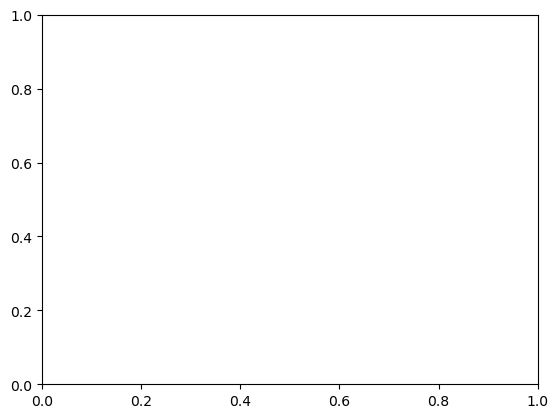